In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')

In [2]:
df = pd.read_csv('../data/processed/customer_features.csv')

print(f"Total customers: {len(df)}")
print(f"Churn rate: {df['Churn'].mean()*100:.2f}%")

df.head()

Total customers: 4191
Churn rate: 33.14%


,CustomerID,Recency,Frequency,Monetary,AvgOrderValue,ActiveMonths,Churn,LogMonetary
0,12347,2,7,3314.73,473.532857,7,0,8.106433
1,12348,249,3,90.20,30.066667,3,1,4.513055
2,12349,19,1,999.15,999.150000,1,0,6.907905
3,12350,310,1,294.40,294.400000,1,1,5.688330
4,12352,36,7,1130.94,161.562857,4,0,7.031688


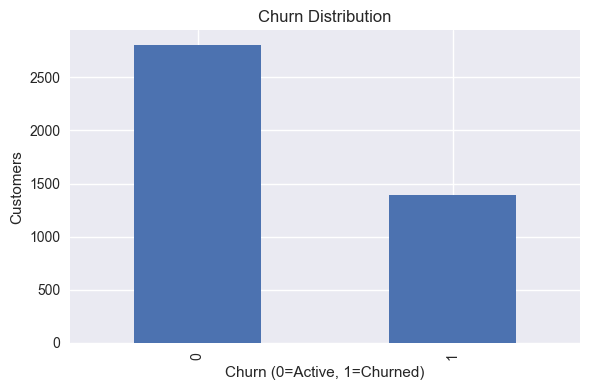

In [3]:
plt.figure(figsize=(6,4))
df['Churn'].value_counts().plot(kind='bar')
plt.title('Churn Distribution')
plt.xlabel('Churn (0=Active, 1=Churned)')
plt.ylabel('Customers')
plt.tight_layout()
plt.savefig('../visualizations/01_churn_distribution.png')
plt.show()

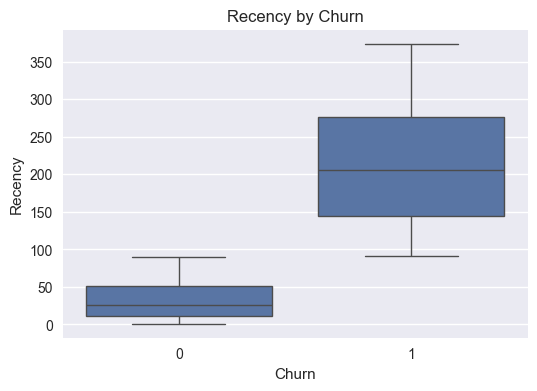

In [4]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='Recency', data=df)
plt.title('Recency by Churn')
plt.savefig('../visualizations/02_recency_vs_churn.png')
plt.show()

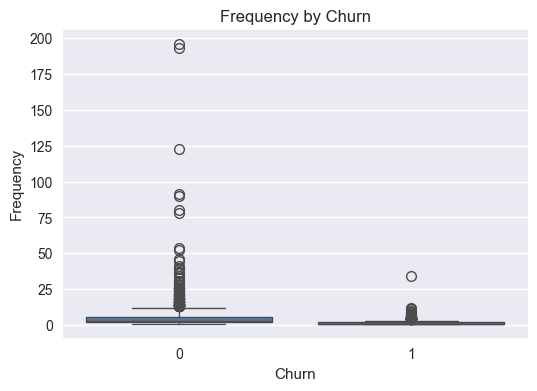

In [5]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='Frequency', data=df)
plt.title('Frequency by Churn')
plt.savefig('../visualizations/03_frequency_vs_churn.png')
plt.show()

Using monetary column: Monetary


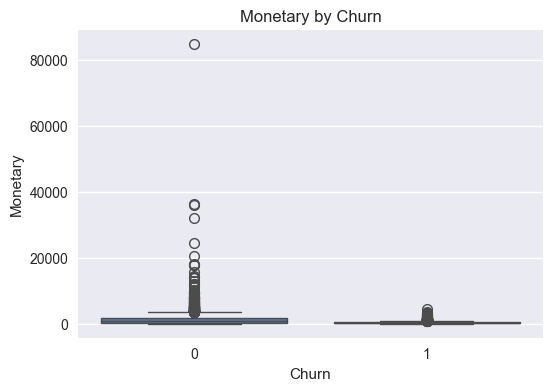

In [7]:
# Identify monetary column safely
monetary_col = None
for col in df.columns:
    if col.lower() in ['totalspent', 'total_spent', 'totalprice', 'monetary']:
        monetary_col = col
        break

print(f"Using monetary column: {monetary_col}")

plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y=monetary_col, data=df)
plt.title(f'{monetary_col} by Churn')
plt.savefig('../visualizations/04_totalspent_vs_churn.png')
plt.show()

In [11]:
# Robust creation of RFM_Score for EDA (handles duplicate values safely)

# Identify monetary column safely
monetary_col = None
for col in df.columns:
    if col.lower() in ['totalspent', 'total_spent', 'totalprice', 'monetary']:
        monetary_col = col
        break

print(f"Using monetary column: {monetary_col}")

# --- Recency score (lower recency = better) ---
df['RecencyScore'] = pd.qcut(
    df['Recency'],
    q=4,
    duplicates='drop'
).cat.codes

df['RecencyScore'] = df['RecencyScore'].max() - df['RecencyScore'] + 1

# --- Frequency score (higher = better) ---
df['FrequencyScore'] = pd.qcut(
    df['Frequency'],
    q=4,
    duplicates='drop'
).cat.codes + 1

# --- Monetary score (higher = better) ---
df['MonetaryScore'] = pd.qcut(
    df[monetary_col],
    q=4,
    duplicates='drop'
).cat.codes + 1

# --- Final RFM Score ---
df['RFM_Score'] = (
    df['RecencyScore'] +
    df['FrequencyScore'] +
    df['MonetaryScore']
)

df[['Recency', 'Frequency', monetary_col, 'RFM_Score']].head()

Using monetary column: Monetary


,Recency,Frequency,Monetary,RFM_Score
0,2,7,3314.73,11
1,249,3,90.20,4
2,19,1,999.15,7
3,310,1,294.40,4
4,36,7,1130.94,10


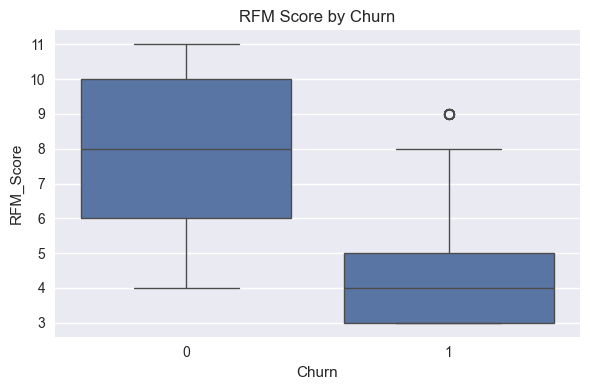

In [12]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='RFM_Score', data=df)
plt.title('RFM Score by Churn')
plt.tight_layout()
plt.savefig('../visualizations/05_rfm_score_vs_churn.png')
plt.show()

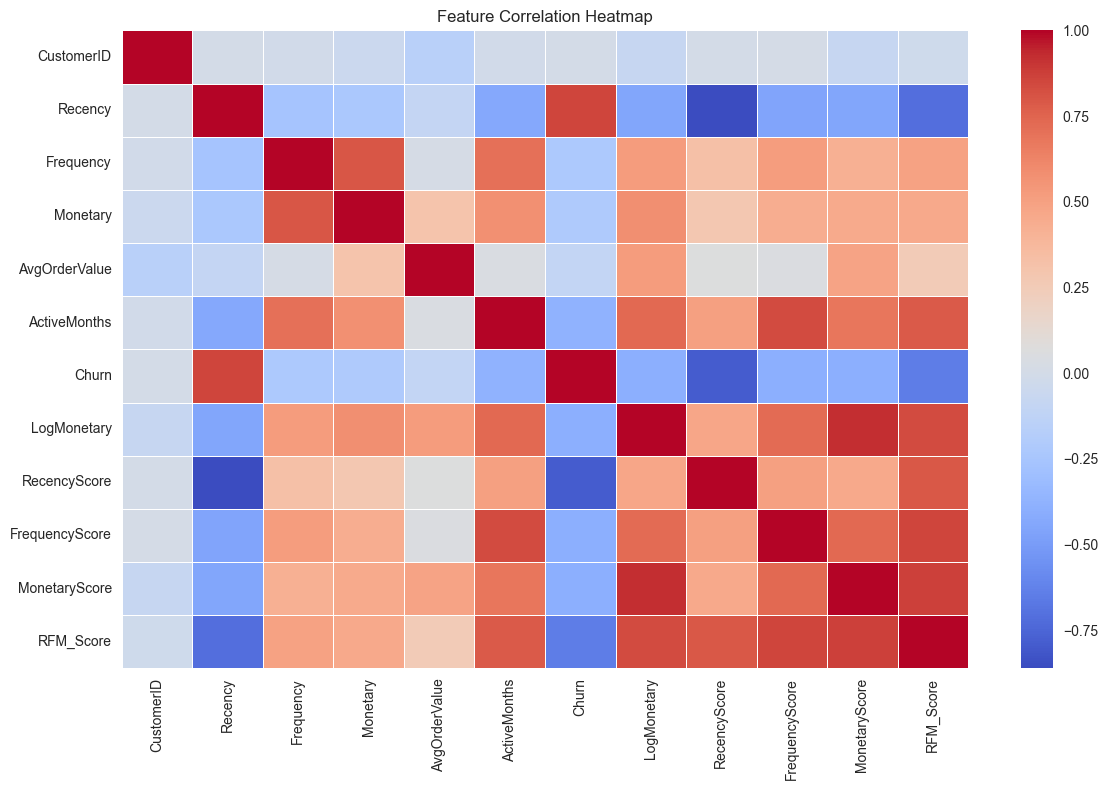

In [13]:
plt.figure(figsize=(12,8))
numeric_df = df.select_dtypes(include=np.number)
corr = numeric_df.corr()

sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('../visualizations/06_correlation_heatmap.png')
plt.show()

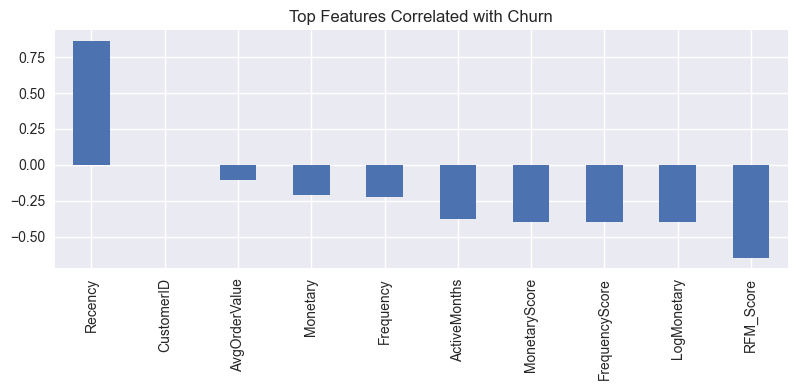

In [14]:
churn_corr = corr['Churn'].drop('Churn').sort_values(ascending=False)

plt.figure(figsize=(8,4))
churn_corr.head(10).plot(kind='bar')
plt.title('Top Features Correlated with Churn')
plt.tight_layout()
plt.savefig('../visualizations/07_top_churn_correlations.png')
plt.show()

In [15]:
if 'PurchaseVelocity' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y='PurchaseVelocity', data=df)
    plt.title('Purchase Velocity vs Churn')
    plt.tight_layout()
    plt.savefig('../visualizations/08_velocity_vs_churn.png')
    plt.show()
else:
    print("PurchaseVelocity column not found — skipping plot")

PurchaseVelocity column not found — skipping plot


In [16]:
if 'Purchases_Last30Days' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y='Purchases_Last30Days', data=df)
    plt.title('Purchases in Last 30 Days vs Churn')
    plt.tight_layout()
    plt.savefig('../visualizations/09_recent30_vs_churn.png')
    plt.show()
else:
    print("Purchases_Last30Days column not found — skipping plot")

Purchases_Last30Days column not found — skipping plot


In [17]:
if 'Purchases_Last90Days' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y='Purchases_Last90Days', data=df)
    plt.title('Purchases in Last 90 Days vs Churn')
    plt.tight_layout()
    plt.savefig('../visualizations/10_recent90_vs_churn.png')
    plt.show()
else:
    print("Purchases_Last90Days column not found — skipping plot")

Purchases_Last90Days column not found — skipping plot


In [18]:
if 'CustomerSegment' in df.columns:
    segment_churn = df.groupby('CustomerSegment')['Churn'].mean()

    plt.figure(figsize=(7,4))
    segment_churn.plot(kind='bar')
    plt.title('Churn Rate by Customer Segment')
    plt.tight_layout()
    plt.savefig('../visualizations/11_segment_churn.png')
    plt.show()
else:
    print("CustomerSegment column not found — skipping plot")

CustomerSegment column not found — skipping plot


In [19]:
if 'CustomerSegment' in df.columns:
    plt.figure(figsize=(7,4))
    df['CustomerSegment'].value_counts().plot(kind='bar')
    plt.title('Customer Segment Distribution')
    plt.tight_layout()
    plt.savefig('../visualizations/12_segment_distribution.png')
    plt.show()
else:
    print("CustomerSegment column not found — skipping plot")

CustomerSegment column not found — skipping plot


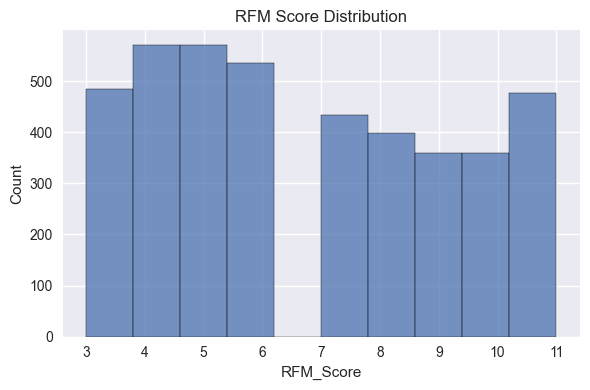

In [20]:
plt.figure(figsize=(6,4))
sns.histplot(df['RFM_Score'], bins=10)
plt.title('RFM Score Distribution')
plt.tight_layout()
plt.savefig('../visualizations/13_rfm_distribution.png')
plt.show()

In [21]:
churned = df[df['Churn'] == 1]['Recency']
active = df[df['Churn'] == 0]['Recency']

t_stat, p_value = stats.ttest_ind(churned, active, equal_var=False)
print(f"T-test (Recency) → t={t_stat:.4f}, p={p_value:.6f}")

T-test (Recency) → t=81.9863, p=0.000000


In [22]:
churned_f = df[df['Churn'] == 1]['Frequency']
active_f = df[df['Churn'] == 0]['Frequency']

t_stat, p_value = stats.ttest_ind(churned_f, active_f, equal_var=False)
print(f"T-test (Frequency) → t={t_stat:.4f}, p={p_value:.6f}")

T-test (Frequency) → t=-20.5383, p=0.000000


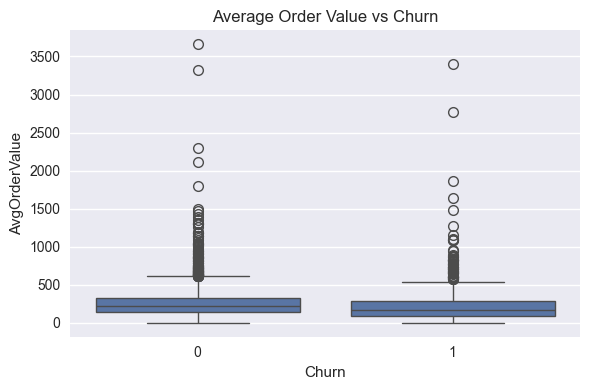

In [23]:
if 'AvgOrderValue' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y='AvgOrderValue', data=df)
    plt.title('Average Order Value vs Churn')
    plt.tight_layout()
    plt.savefig('../visualizations/14_aov_vs_churn.png')
    plt.show()
else:
    print("AvgOrderValue column not found — skipping plot")

In [24]:
if 'TotalItems' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y='TotalItems', data=df)
    plt.title('Total Items Purchased vs Churn')
    plt.tight_layout()
    plt.savefig('../visualizations/15_items_vs_churn.png')
    plt.show()
else:
    print("TotalItems column not found — skipping plot")

TotalItems column not found — skipping plot
